# Network Analysis

# Obtain routable network

In [1]:
import osmnx as ox

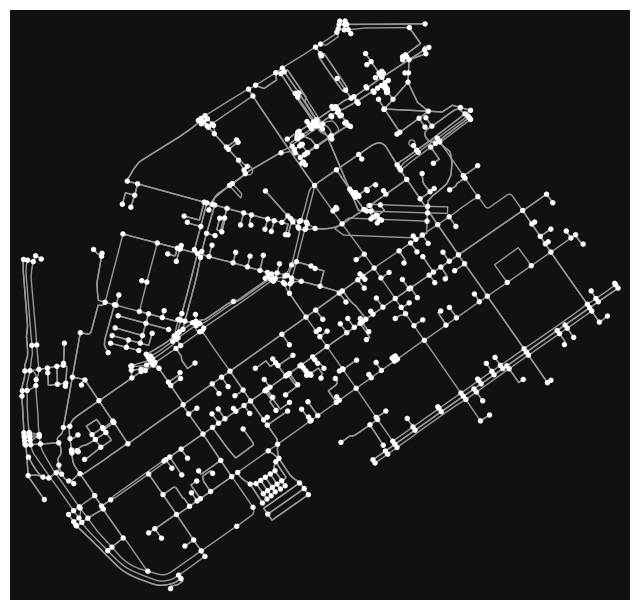

In [2]:
KAMPPI = 'Kamppi, Helsinki, Finland'
graph_fi = ox.graph_from_place(
    KAMPPI, 
    network_type='bike'
)
f, ax = ox.plot_graph(graph_fi)

>Add buffer to ensure shortest route includes areas a little outside the city

In [3]:
place_poly = ox.geocode_to_gdf(KAMPPI).to_crs(3067)

In [4]:
place_poly['geometry'] = place_poly.buffer(200).to_crs(4326)

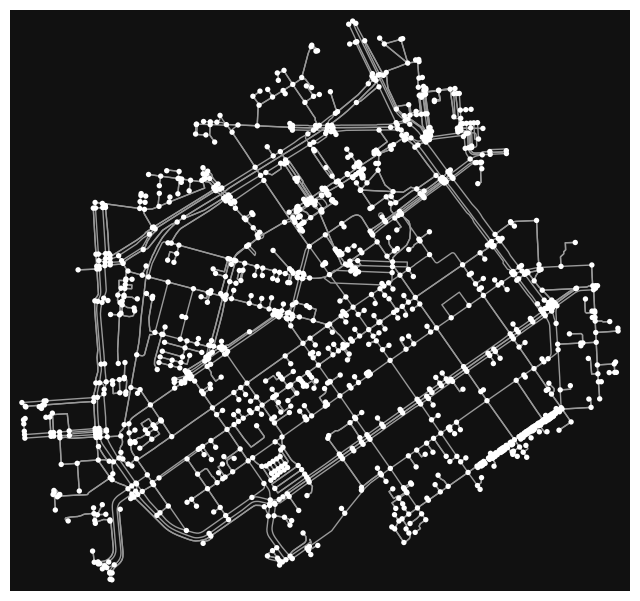

In [5]:
graph_fi = ox.graph_from_polygon(
    place_poly.at[0, 'geometry'], 
    network_type='bike'
)
f, ax = ox.plot_graph(graph_fi);

# Data Overview

>Retrieve only the edges

In [7]:
edges = ox.graph_to_gdfs(graph_fi, nodes=False, edges=True)
edges.columns

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'reversed',
       'length', 'geometry', 'junction', 'width', 'access', 'bridge',
       'service', 'tunnel'],
      dtype='object')

In [ ]:
graph_fi = ox.project_graph(graph_fi)

In [8]:
edges.highway.value_counts()

highway
service                      981
pedestrian                   560
residential                  463
cycleway                     457
tertiary                     238
primary                      165
secondary                    123
unclassified                  45
[pedestrian, service]         16
path                          10
living_street                  8
[cycleway, pedestrian]         6
[cycleway, residential]        4
[living_street, service]       4
[pedestrian, residential]      2
[residential, pedestrian]      2
tertiary_link                  2
[cycleway, service]            2
primary_link                   1
[unclassified, service]        1
Name: count, dtype: int64

>Transform to projected reference system

In [10]:
graph_fi = ox.project_graph(graph_fi)

In [11]:
nodes, edges = ox.graph_to_gdfs(graph_fi)
nodes.crs

<Projected CRS: EPSG:32635>
Name: WGS 84 / UTM zone 35N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 24°E and 30°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Bulgaria. Central African Republic. Democratic Republic of the Congo (Zaire). Egypt. Estonia. Finland. Greece. Latvia. Lesotho. Libya. Lithuania. Moldova. Norway. Poland. Romania. Russian Federation. Sudan. Svalbard. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (24.0, 0.0, 30.0, 84.0)
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Analyze network properties

In [12]:
ox.basic_stats(graph_fi)

{'n': 1445,
 'm': 3090,
 'k_avg': 4.27681660899654,
 'edge_length_total': 97528.07391525751,
 'edge_length_avg': 31.562483467720877,
 'streets_per_node_avg': 2.617993079584775,
 'streets_per_node_counts': {0: 0, 1: 434, 2: 16, 3: 683, 4: 292, 5: 20},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.30034602076124567,
  2: 0.011072664359861591,
  3: 0.4726643598615917,
  4: 0.20207612456747404,
  5: 0.01384083044982699},
 'intersection_count': 1011,
 'street_length_total': 60703.73649214235,
 'street_segment_count': 1849,
 'street_length_avg': 32.830576794019656,
 'circuity_avg': 1.0416864004193636,
 'self_loop_proportion': 0.001081665765278529}

>OSMnx does not consider the area covered by the network, so does not provide density measures by default. To manually do so, create a convex hull.

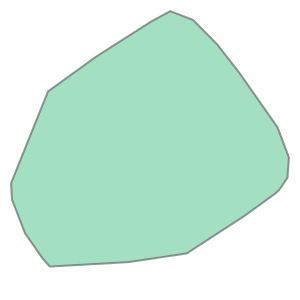

In [14]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [15]:
stats = ox.basic_stats(graph_fi, area=convex_hull.area)
stats

{'n': 1445,
 'm': 3090,
 'k_avg': 4.27681660899654,
 'edge_length_total': 97528.07391525751,
 'edge_length_avg': 31.562483467720877,
 'streets_per_node_avg': 2.617993079584775,
 'streets_per_node_counts': {0: 0, 1: 434, 2: 16, 3: 683, 4: 292, 5: 20},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.30034602076124567,
  2: 0.011072664359861591,
  3: 0.4726643598615917,
  4: 0.20207612456747404,
  5: 0.01384083044982699},
 'intersection_count': 1011,
 'street_length_total': 60703.73649214235,
 'street_segment_count': 1849,
 'street_length_avg': 32.830576794019656,
 'circuity_avg': 1.0416864004193636,
 'self_loop_proportion': 0.001081665765278529,
 'node_density_km': 835.1729594139833,
 'intersection_density_km': 584.3320844066001,
 'edge_density_km': 56368.72672508742,
 'street_density_km': 35085.20363572951}

# Shortest path

>Origin and destination points

In [17]:
origin = (
    ox.geocode_to_gdf("Maria 01, Helsinki")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    ox.geocode_to_gdf("ruttopuisto")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

>Nearest node

In [19]:
origin_node_id = ox.nearest_nodes(graph_fi, origin.x, origin.y)
origin_node_id

319719983

In [20]:
destination_node_id = ox.nearest_nodes(graph_fi, 
                                       destination.x,
                                       destination.y)
destination_node_id

1377209035

>Routing

In [21]:
route = ox.shortest_path(graph_fi, origin_node_id, destination_node_id)
route

[319719983,
 11702007434,
 1382316822,
 1382316829,
 1382316852,
 5464887863,
 1382320461,
 5154747161,
 1378064352,
 1372461709,
 1372441203,
 3205236795,
 3205236793,
 8244768393,
 56115897,
 7699019923,
 7699019916,
 7699019908,
 7699019903,
 267117319,
 1897461604,
 724233143,
 724233128,
 267117317,
 846597945,
 846597947,
 2037356632,
 1547012339,
 569742461,
 1372441189,
 4524927399,
 298372061,
 7702074840,
 7702074833,
 60170471,
 8856704555,
 3227176325,
 7676757030,
 8856704573,
 7676756995,
 8856704588,
 1377211668,
 60170470,
 8874925445,
 3228706311,
 12124374263,
 1377211669,
 1377209035]

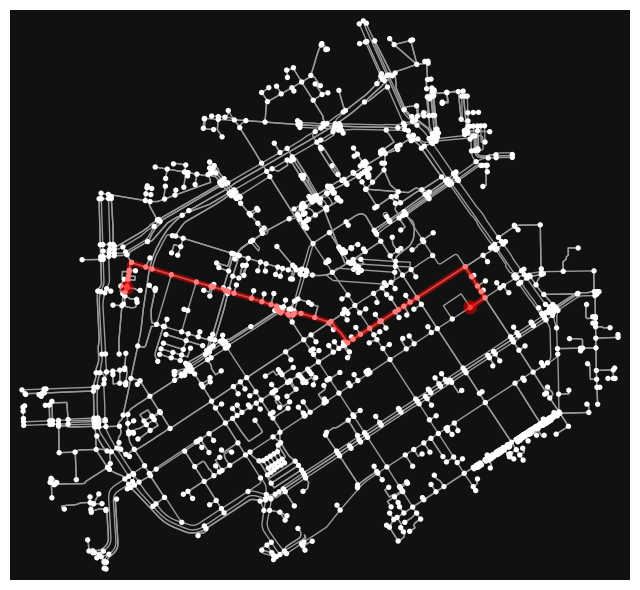

In [22]:
f, ax = ox.plot_graph_route(graph_fi, route)

>Saving to disk

In [23]:
route_nodes = nodes.loc[route]

In [24]:
import shapely.geometry

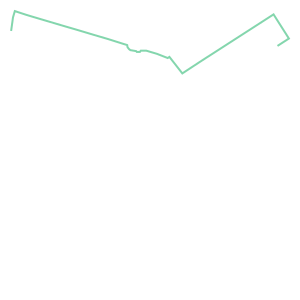

In [25]:
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

In [26]:
import geopandas as gpd

In [27]:
route_geom = gpd.GeoDataFrame(
    {
        'geometry': [route_line], 
        'osm_nodes': [route]
    }, 
    crs=edges.crs
)

In [28]:
route_geom['length_m'] = route_geom.length 
route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (384706.296 6671815.989, 384706.911...","[319719983, 11702007434, 1382316822, 138231682...",1283.164552


In [29]:
buildings = ox.features_from_place(
    KAMPPI,
    {
        "building" : True
    }
).to_crs(edges.crs)

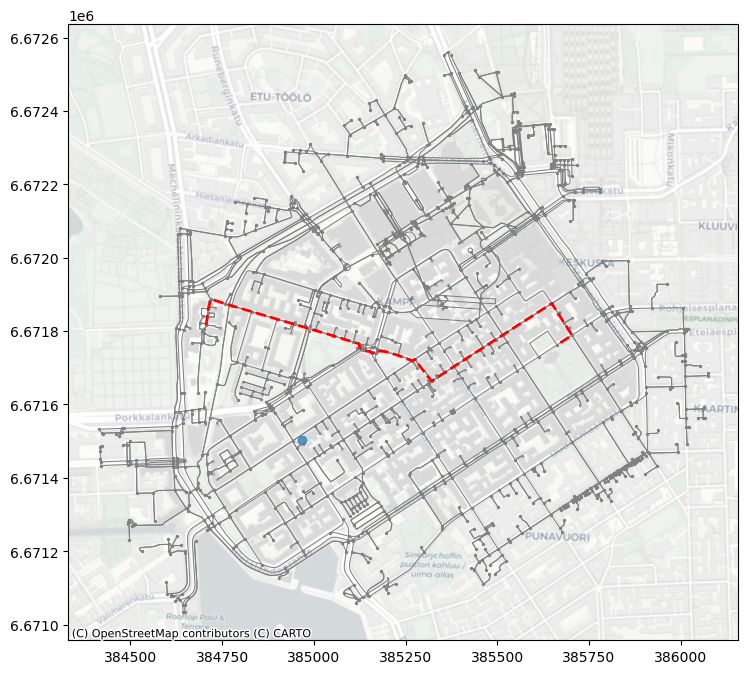

In [30]:
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
ctx.add_basemap(ax, crs=buildings.crs, source=ctx.providers.CartoDB.Positron);

>Prepare data for saving to file

In [31]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
]
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [32]:
route_geom['osm_nodes'] = route_geom.osm_nodes.astype(str)

In [33]:
output_gpkg = "../data/local/OSM_Kamppi.gpkg"

edges.to_file(output_gpkg, layer='streets')
route_geom.to_file(output_gpkg, layer='route')
nodes.to_file(output_gpkg, layer='nodes')

In [34]:
buildings.columns

Index(['geometry', 'addr:city', 'addr:housenumber', 'addr:postcode',
       'addr:street', 'building', 'name', 'opening_hours', 'operator', 'phone',
       ...
       'unisex', 'covered', 'area', 'leisure', 'construction', 'type', 'ele',
       'electrified', 'note', 'nohousenumber'],
      dtype='object', length=119)

In [35]:
buildings[['geometry', 'name', 'addr:street']].to_file(
    output_gpkg, layer='buildings'
)

In [37]:
display(buildings.describe())

,geometry,addr:city,addr:housenumber,addr:postcode,addr:street,building,name,opening_hours,operator,phone,...,unisex,covered,area,leisure,construction,type,ele,electrified,note,nohousenumber
count,451,151,191,123,193,451,58,8,2,5,...,1,1,1,1,1,35,1,1,3,2
unique,451,1,66,3,35,27,57,8,2,5,...,1,1,1,1,1,1,1,1,1,1
top,"POLYGON ((385699.8198088626 6671606.447511866,...",Helsinki,2-10,00100,Kalevankatu,yes,Suomitalo,Mo-Fr 11:00-18:00,Nice Bike Oy,+358 452250669,...,yes,yes,yes,sauna,commercial,multipolygon,5,yes,Koko ja asemointi korjattu. Näkyvät aika hyvin...,yes
freq,1,151,14,59,27,199,2,1,1,1,...,1,1,1,1,1,35,1,1,3,2


In [38]:
buildings.describe()

,geometry,addr:city,addr:housenumber,addr:postcode,addr:street,building,name,opening_hours,operator,phone,...,unisex,covered,area,leisure,construction,type,ele,electrified,note,nohousenumber
count,451,151,191,123,193,451,58,8,2,5,...,1,1,1,1,1,35,1,1,3,2
unique,451,1,66,3,35,27,57,8,2,5,...,1,1,1,1,1,1,1,1,1,1
top,"POLYGON ((385699.8198088626 6671606.447511866,...",Helsinki,2-10,00100,Kalevankatu,yes,Suomitalo,Mo-Fr 11:00-18:00,Nice Bike Oy,+358 452250669,...,yes,yes,yes,sauna,commercial,multipolygon,5,yes,Koko ja asemointi korjattu. Näkyvät aika hyvin...,yes
freq,1,151,14,59,27,199,2,1,1,1,...,1,1,1,1,1,35,1,1,3,2
